In [1]:
import numpy as np 
import pandas as pd 

In [2]:
filepath = 'BTC-USDT-from-2023-09-01-to-2023-10-19.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Timestamp')
data['Date'] = data['Timestamp']
data.head()

,Timestamp,Open,High,Low,Close,Volume,Date
0,2023-09-01 00:15:00,25989.4,26033.1,25987.8,26027.7,1.0,2023-09-01 00:15:00
1,2023-09-01 00:30:00,26027.7,26065.5,26017.7,26039.6,1.0,2023-09-01 00:30:00
2,2023-09-01 00:45:00,26039.6,26058.3,26033.9,26051.7,1.0,2023-09-01 00:45:00
3,2023-09-01 01:00:00,26051.7,26056.1,26008.2,26024.8,1.0,2023-09-01 01:00:00
4,2023-09-01 01:15:00,26024.6,26024.6,25990.4,26000.3,1.0,2023-09-01 01:15:00


In [3]:
data.shape

(4561, 7)

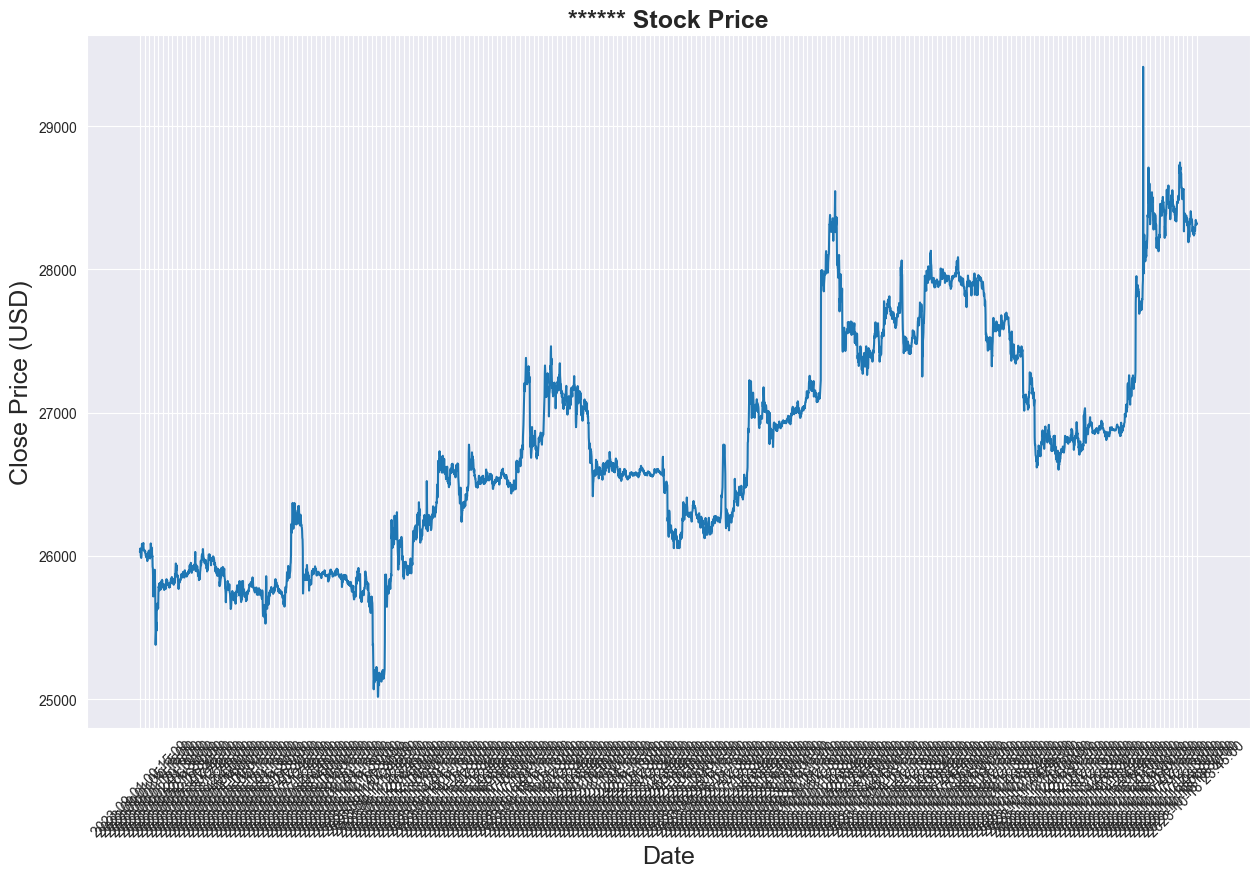

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],20), data['Date'].loc[::20], rotation=45)
plt.title("****** Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

# 1. 特征工程

In [5]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4561 entries, 0 to 4560
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4561 non-null   float64
dtypes: float64(1)
memory usage: 35.8 KB


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/l3/3nn8r4195jx8b6rzwks1y1pr0000gn/T/ipykernel_4514/68737012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [7]:
price['Close'].shape

(4561,)

# 2. 数据集制作

In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [9]:
lookback = 12
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3633, 19, 1)
y_train.shape =  (3633, 1)
x_test.shape =  (908, 19, 1)
y_test.shape =  (908, 1)


注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)

# 3. 模型构建 —— LSTM

In [10]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [11]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [13]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. 模型训练

In [14]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.11511705070734024
Epoch  1 MSE:  0.11038057506084442
Epoch  2 MSE:  0.09829316288232803
Epoch  3 MSE:  0.09134764224290848
Epoch  4 MSE:  0.07973828911781311
Epoch  5 MSE:  0.05584460869431496
Epoch  6 MSE:  0.03140890598297119
Epoch  7 MSE:  0.007334921974688768
Epoch  8 MSE:  0.05486307293176651
Epoch  9 MSE:  0.014018459245562553
Epoch  10 MSE:  0.007498814724385738
Epoch  11 MSE:  0.008608455769717693
Epoch  12 MSE:  0.011949471198022366
Epoch  13 MSE:  0.017057286575436592
Epoch  14 MSE:  0.01824302040040493
Epoch  15 MSE:  0.015418043360114098
Epoch  16 MSE:  0.011363719590008259
Epoch  17 MSE:  0.00919430423527956
Epoch  18 MSE:  0.007068840321153402
Epoch  19 MSE:  0.0031695528887212276
Epoch  20 MSE:  0.0025546704418957233
Epoch  21 MSE:  0.00474205007776618
Epoch  22 MSE:  0.005966298282146454
Epoch  23 MSE:  0.0061227320693433285
Epoch  24 MSE:  0.0065872021950781345
Epoch  25 MSE:  0.005277423653751612
Epoch  26 MSE:  0.0029216136317700148
Epoch  27 MSE:  0

# 5. 模型结果可视化

In [15]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

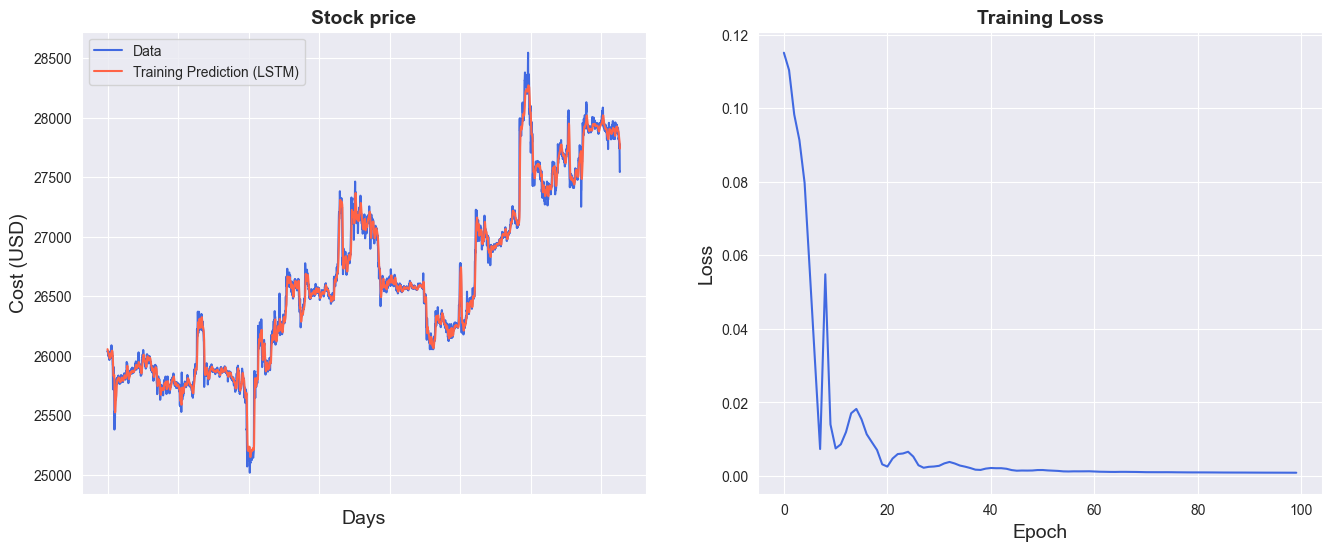

In [16]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# 6. 模型验证

In [17]:
x_test[-1]

tensor([[0.5104],
        [0.4921],
        [0.4767],
        [0.4835],
        [0.4914],
        [0.4691],
        [0.4816],
        [0.4875],
        [0.4646],
        [0.4709],
        [0.4685],
        [0.4827],
        [0.4866],
        [0.4799],
        [0.4985],
        [0.4991],
        [0.5140],
        [0.5082],
        [0.5084]])

In [18]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 65.55 RMSE
Test Score: 100.45 RMSE


In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [20]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()